# Computer Vision: Face Mask Prediction using U-Net

### George Mathew

### Task is to predict the mask around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow
%tensorflow_version 2.x
tensorflow.__version__


'2.3.0'

In [ ]:
import random
random.seed(0)
tensorflow.random.set_seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### Load the "images.npy" file 
- This file contains images with details of bounding boxes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:

data = np.load('/content/drive/My Drive/AIML/Module 9/images.npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file


In [ ]:
# Printing details of one of the images
print(data[100][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.26327193932827736, 'y': 0.18497109826589594}, {'x': 0.3206933911159263, 'y': 0.28516377649325625}], 'imageWidth': 1280, 'imageHeight': 720}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.4257854821235103, 'y': 0.23121387283236994}, {'x': 0.49837486457204766, 'y': 0.34104046242774566}], 'imageWidth': 1280, 'imageHeight': 720}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.6197183098591549, 'y': 0.29865125240847784}, {'x': 0.6988082340195017, 'y': 0.4624277456647399}], 'imageWidth': 1280, 'imageHeight': 720}]


In [ ]:
# Shape of the above image
print(data[100][0].shape)

(720, 1280, 3)


### Set image dimensions 
- Initialize image height, image width with value: 224 

In [ ]:
#Initialising the values for the image for processing

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Set other Hyper Parameters

In [ ]:
# Setting other hyper parameters
EPOCH = 30
BATCH = 4
LR = 1e-4

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing
- 400 images in training
- 9 images in testing data

Training data

In [ ]:
# Setting the training data
X_train = X[:400]
y_train = masks[:400]
print(X_train.shape)
print(y_train.shape)

(400, 224, 224, 3)
(400, 224, 224)


Testing data

In [ ]:
# Setting the test data
X_test = X[400:]
y_test = masks[400:]
print(X_test.shape)
print(y_test.shape)

(9, 224, 224, 3)
(9, 224, 224)


### Print a sample training image, image array and its mask

Print the image and image array and Mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


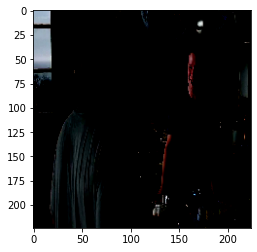

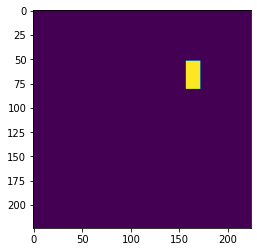

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


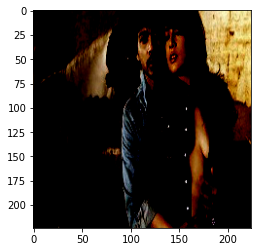

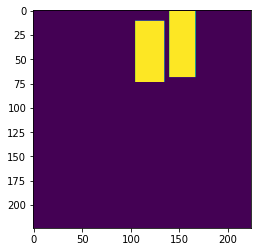

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


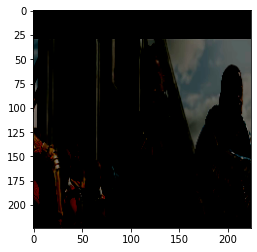

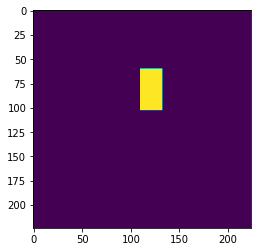

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


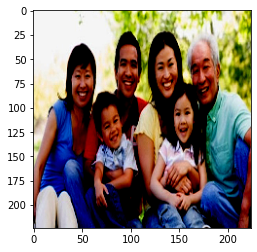

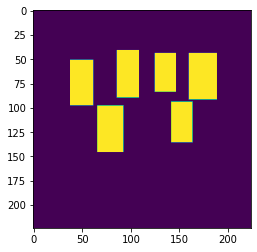

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


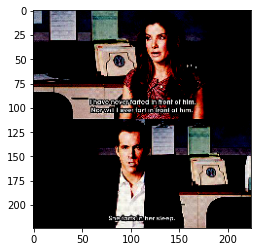

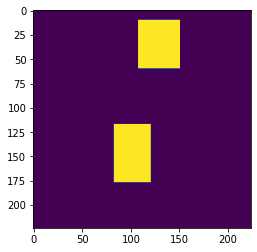

In [ ]:
# Print a few of the images and the set masks to see how it looks 

for x in range(5):
  plt.imshow((X_train[x+1]))
  plt.show()
  plt.imshow((y_train[x+1]))
  plt.show()
  

## Create the model
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [ ]:
# importing librarise needed for defining the model
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Input, Concatenate, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
# Create the model. 
# We use the MobileNet architecture and then adapt it to the U-Net architecture. 

# MobileNet has less parameters, due to which it is easy to train.
# Using a pretrained encoder helps the model to converge much faster in comparison to the non-pretrained model.
# A pretrained encoder helps the model to achieve high performance as compared to non-pretrained model.



def create_model(trainable=True):
  inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name="input_image")

  encoder = MobileNet(input_tensor=inputs, weights="imagenet", include_top=False, alpha=1)
  skip_connection_names = ["input_image", "conv_pw_1_relu", "conv_pw_3_relu", "conv_pw_5_relu"]
  encoder_output = encoder.get_layer("conv_pw_11_relu").output #(14x14) output
  #encode.summary()

  for layer in encoder.layers:
      layer.trainable = trainable

  f = [14, 28, 56, 112]
  x = encoder_output

  for i in range(1, len(skip_connection_names)+1, 1):
    x_skip = encoder.get_layer(skip_connection_names[-i]).output
    print(x_skip.shape)

    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, x_skip])

    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
            
    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

  x = Conv2D(1, (1, 1), padding="same")(x)
  x = Activation("sigmoid")(x)
    
  model = Model(inputs, x)
  return model

### Call the create_model function
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [ ]:
# I opted to train the layers as it gave better Recall and Accuracy without increasing the training time by too much. 
# I noticed a 4-5% improvement in Recall and Accuracy by trianing the layers. 

model = create_model(True)

17227776/17225924 [==============================] - 0s 0us/step
(None, 28, 28, 256)
(None, 56, 56, 128)
(None, 112, 112, 64)
(None, 224, 224, 3)


### Print model summary

In [ ]:
model.summary()

# The model summary clearly shows the "U" shape of the model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function
- Create a function to calculate dice coefficient


In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss function

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Compile the model
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [ ]:
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coefficient, Recall(), Precision()]
model.compile(loss=loss, optimizer=opt, metrics=metrics)

### Define callbacks
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [ ]:
callbacks = [
    ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.001),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
]

### Fit the model
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [ ]:

model.fit(
    X_train, 
    y_train,
    validation_data = (X_test, y_test),
    epochs = EPOCH,
    batch_size = BATCH,
    callbacks = callbacks
)

Epoch 1/30
  1/100 [..............................] - ETA: 0s - loss: 2.9402 - dice_coefficient: 0.1445 - recall: 0.7549 - precision: 0.0801WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 1.9719 - dice_coefficient: 0.3017 - recall: 0.9174 - precision: 0.2349
Epoch 00001: val_loss improved from inf to 2.06322, saving model to model-2.06.h5
100/100 [==============================] - 6s 63ms/step - loss: 1.9719 - dice_coefficient: 0.3017 - recall: 0.9174 - precision: 0.2349 - val_loss: 2.0632 - val_dice_coefficient: 0.2521 - val_recall: 0.9609 - val_precision: 0.3523
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.5594 - dice_coefficient: 0.3643 - recall: 0.9122 - precision: 0.4843

## The Model Performance
###- loss: 0.4745
###- dice_coefficient: 0.7006
###- recall: 0.9755
###- precision: 0.9476

### Get the predicted mask for a test image 

Show the test image

Show original mask for test image

Predict the mask on the test image

### Impose the mask on the test image 
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

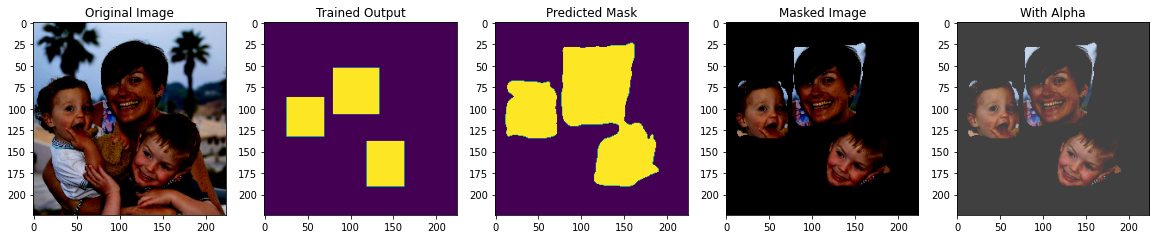

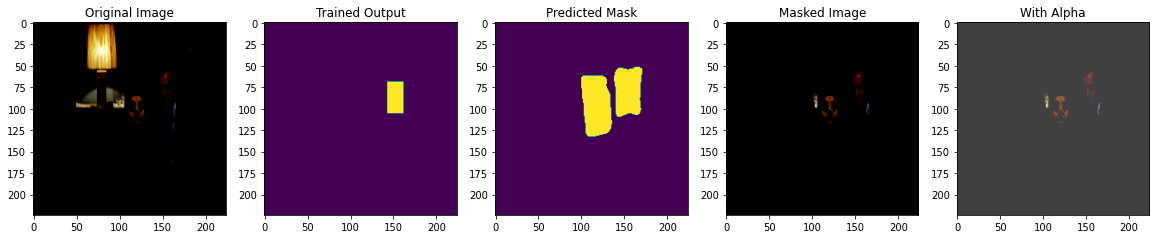

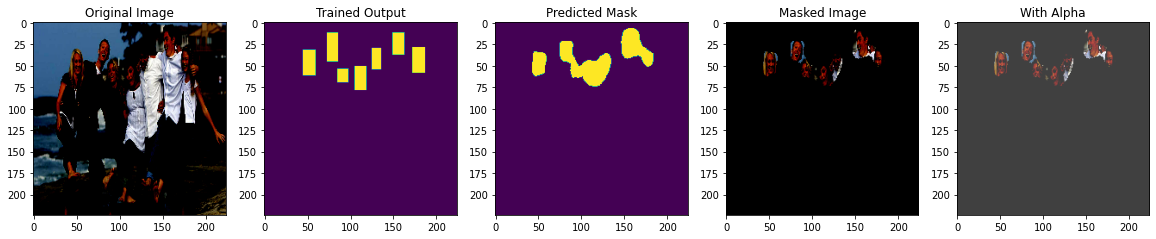

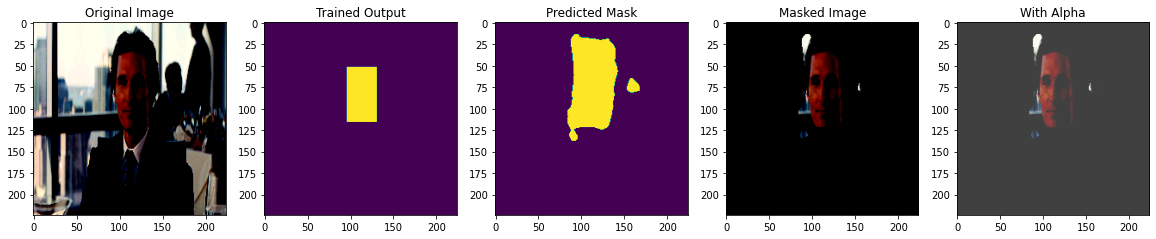

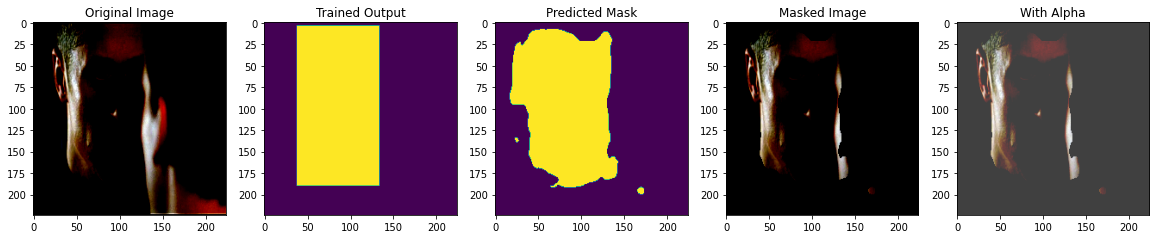

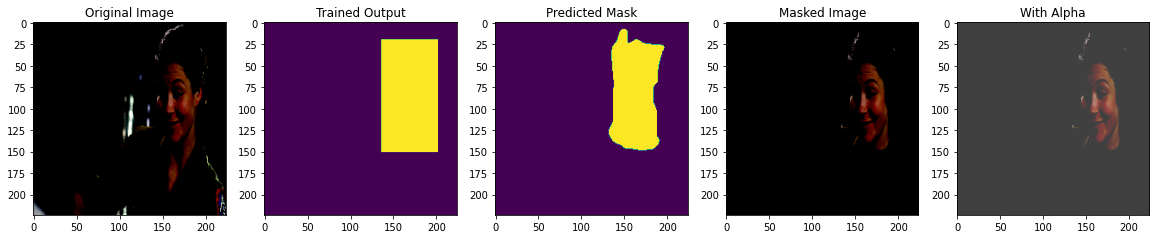

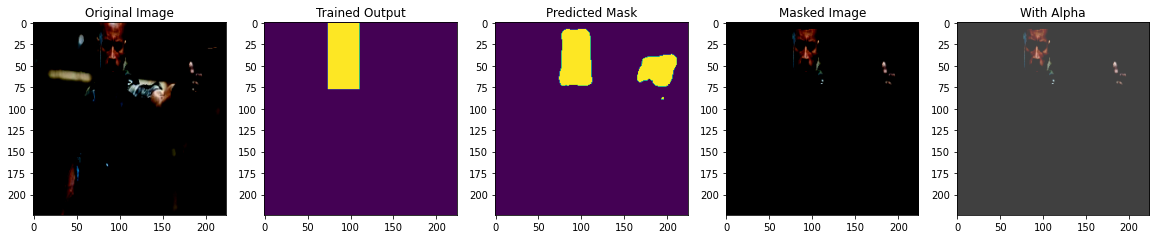

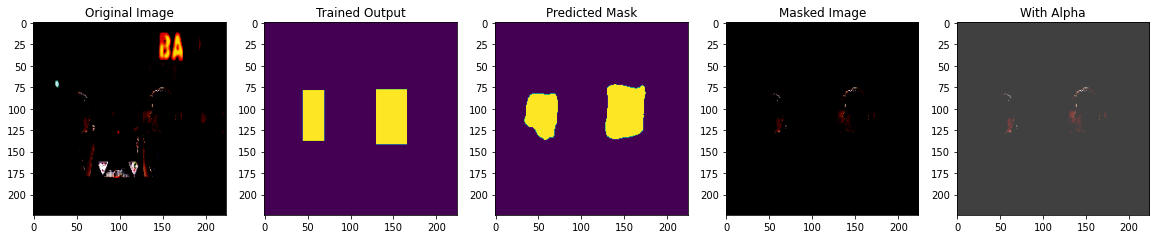

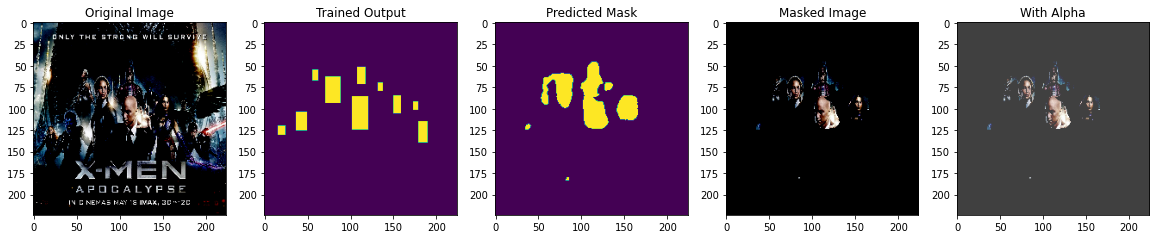

In [ ]:
#### Add your code here ####
def prediction_image(pred_image):
  image = pred_image
  pred_mask = cv2.resize(1.0*(model.predict(np.expand_dims(x, axis=0))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))
  
  image2 = image
  image2[:,:,0] = pred_mask*image[:,:,0]
  image2[:,:,1] = pred_mask*image[:,:,1]
  image2[:,:,2] = pred_mask*image[:,:,2]
  return pred_mask, image2

for i, (x, y) in enumerate(zip(X_test[:10], y_test[:10])):
  fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(20, 5))
  #Image
  ax1.imshow(X_test[i])
  ax1.set_title("Original Image")
  #Trained Output
  ax2.imshow(y_test[i])
  ax2.set_title("Trained Output")
  #Predicted Mask
  mask, masked_image = prediction_image(X_test[i].copy())
  ax3.imshow(mask)
  ax3.set_title("Predicted Mask")
  ax4.imshow(masked_image)
  ax4.set_title("Masked Image")
  ax5.imshow(masked_image, alpha=.75)
  ax5.set_title("With Alpha")